In [1]:
import iris
from iris.experimental.equalise_cubes import equalise_attributes
from iris.util import unify_time_units
import iris.analysis.cartography
import iris.coord_categorisation
import matplotlib.pyplot as pl
from climateforcing.utils import mkdir_p
import numpy as np
#import pickle
import scipy.stats as st
from tqdm import tqdm

In [2]:
import cartopy

In [3]:
era5heatdir = '/gws/pw/j05/cop26_hackathons/bristol/project10/era5-heat_1deg/'
modeldir = '/gws/pw/j05/cop26_hackathons/bristol/project10/utci_projections_1deg/HadGEM3-GC31-LL/historical/r1i1p1f3/'

In [4]:
cube_era5 = iris.load(era5heatdir + 'ECMWF_utci_*_v1.0_con.nc')
equalise_attributes(cube_era5)
unify_time_units(cube_era5)
cube_era5 = cube_era5.concatenate_cube()

In [5]:
iris.coord_categorisation.add_month(cube_era5, 'time', name='month')
iris.coord_categorisation.add_year(cube_era5, 'time', name='year')
cube_era5_month = cube_era5.aggregated_by(['month','year'], iris.analysis.MEAN)
cube_era5_month

<iris 'Cube' of utci / (1) (time: 180; latitude: 180; longitude: 360)>

In [24]:
outdata_era5 = np.ones((180, 180, 360)) * np.ma.masked
for imonth in tqdm(range(180)):
    outdata_era5[imonth, ...] = cube_era5[imonth, ...].data

100%|██████████| 180/180 [00:08<00:00, 20.90it/s]


In [7]:
# just one year
cube_model = iris.load(modeldir + 'utci_3hr_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_19*.nc')
cube_model = cube_model.concatenate_cube()

In [8]:
cube_model.coord('time').points = cube_model.coord('time').points - 1/16
cube_model.coord('time')

DimCoord(array([48600.0625, 48600.1875, 48600.3125, ..., 53999.6875, 53999.8125,
       53999.9375]), standard_name='time', units=Unit('days since 1850-01-01', calendar='360_day'), long_name='time', var_name='time')

In [9]:
#result = cube_model.collapsed('time', iris.analysis.PERCENTILE, percent=[5, 95])

In [10]:
iris.coord_categorisation.add_month(cube_model, 'time', name='month')

In [11]:
iris.coord_categorisation.add_year(cube_model, 'time', name='year')

In [12]:
cube_model_month = cube_model.aggregated_by(['month','year'], iris.analysis.MEAN)

In [13]:
cube_model_month

<iris 'Cube' of Universal Thermal Climate Index / (K) (time: 180; latitude: 180; longitude: 360)>

In [14]:
outdata_model = np.zeros((180, 180, 360))
for imonth in tqdm(range(180)):
    outdata_model[imonth, ...] = cube_model[imonth, ...].data

100%|██████████| 180/180 [00:02<00:00, 71.28it/s]


In [15]:
#cube_mean = cube_model_month.collapsed('time', iris.analysis.MEAN)

In [16]:
#cube_mean.remove_coord('month')
#cube_mean.remove_coord('year')
#cube_mean

In [17]:
#cube_mean.remove_coord('time')
#cube_mean

In [18]:
#cube_model_month[0,...].shape

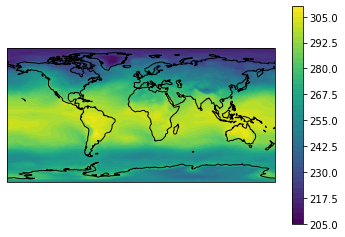

In [19]:
import cartopy.crs as ccrs
ax = pl.axes(projection=ccrs.PlateCarree())

pl.contourf(cube_model.coord('longitude').points, cube_model.coord('latitude').points, outdata_model.mean(axis=0), 40,
             transform=ccrs.PlateCarree())
ax.coastlines()
pl.colorbar()

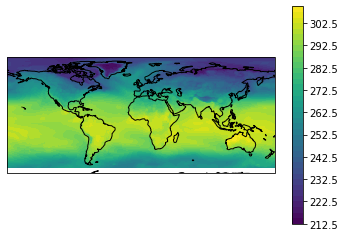

In [27]:
ax = pl.axes(projection=ccrs.PlateCarree())

pl.contourf(cube_model.coord('longitude').points, cube_model.coord('latitude').points, outdata_era5.mean(axis=0), 40,
             transform=ccrs.PlateCarree())
ax.coastlines()
pl.colorbar()

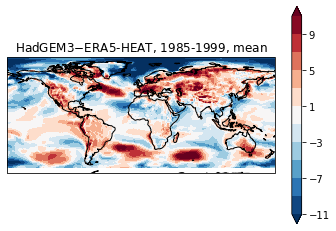

In [38]:
ax = pl.axes(projection=ccrs.PlateCarree())

pl.contourf(cube_model.coord('longitude').points, cube_model.coord('latitude').points, outdata_model.mean(axis=0)-outdata_era5.mean(axis=0), np.arange(-11,12,2), 
            cmap=pl.cm.RdBu_r, extend='both',
             transform=ccrs.PlateCarree())
ax.coastlines()
pl.colorbar()
pl.title('HadGEM3$-$ERA5-HEAT, 1985-1999, mean')
pl.savefig('/home/users/pmcjs/hadgem3_bias.png')